In [1]:
!pip install huggingface_hub -q

In [2]:
!pip install wandb==0.16.0 -q

In [3]:
!pip install --upgrade datasets -q

In [4]:
!pip install git+https://github.com/tensorflow/examples.git
!pip install git+https://github.com/surmenok/keras_lr_finder

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-2j97f9a2
  Running command git clone --filter=blob:none -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-2j97f9a2
  Resolved https://github.com/tensorflow/examples.git to commit fff4bcda7201645a1efaea4534403daf5fc03d42
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/surmenok/keras_lr_finder to /tmp/pip-req-build-_7ad4mf3
  Running command git clone --filter=blob:none -q https://github.com/surmenok/keras_lr_finder /tmp/pip-req-build-_7ad4mf3
  Resolved https://github.com/surmenok/keras_lr_finder to commit 3c8fe719d7e3291a1f72ff8a9a1c51e9fc5d520b
  Preparing metadata (setup.py) ... done


In [5]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import os
import albumentations as A
from tensorflow_examples.models.pix2pix import pix2pix
from tensorflow import keras

In [6]:
from datasets import load_dataset
dataset = load_dataset("nateraw/pascal-voc-2012")

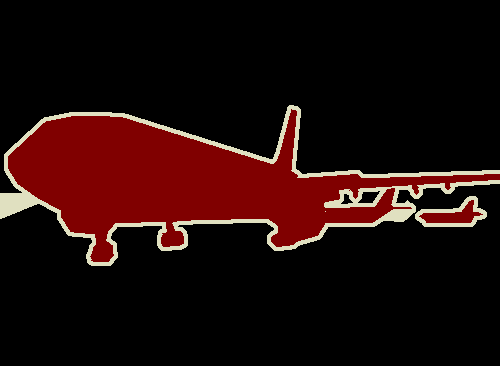

In [7]:
dataset['val']['mask'][0]

In [8]:
IMG_HEIGHT = 256
IMG_WIDTH  = 256

In [9]:
from PIL import ImageOps

def data_concat(dataset):
    
    img_arr = []
    seg_arr = []

    img_arr_temp = dataset['train']['image'] + dataset['val']['image']

    seg_arr_temp = dataset['train']['mask'] + dataset['val']['mask']
    
    for img, seg in zip(img_arr_temp, seg_arr_temp):
        img = np.array(img.resize((IMG_WIDTH, IMG_HEIGHT)))
        seg = np.argmax(np.array(seg.resize((IMG_WIDTH, IMG_HEIGHT))), axis=-1)
        seg[seg == 255] = 21
        img_arr.append(img)
        seg_arr.append(seg)
    
    return np.array(img_arr), np.array(seg_arr)

In [10]:
full_dataset = tf.data.Dataset.from_tensor_slices(data_concat(dataset))

In [11]:
print(full_dataset)

<TensorSliceDataset shapes: ((256, 256, 3), (256, 256)), types: (tf.uint8, tf.int64)>


In [12]:
DATASET_SIZE = 2913

In [13]:
train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.2 * DATASET_SIZE)
test_size = int(0.1 * DATASET_SIZE)

full_dataset = full_dataset.shuffle(buffer_size = DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)

In [14]:
# def Read_Data(path,is_train = True):
#     temp = []
#     updated_path = os.path.join(path,"VOC2012","ImageSets","Segmentation","train.txt" if is_train else "val.txt")
#     with open(updated_path,"r") as file_:
#         Instances = file_.read().split()
#         img_arr = []
#         seg_arr = []
#         for img in Instances:
#             path_img = os.path.join(path,"VOC2012","JPEGImages",img+".jpg")
#             path_seg = os.path.join(path,"VOC2012","SegmentationClass",img+".png")
#             img = np.array(Image.open(path_img).resize((IMG_WIDTH, IMG_HEIGHT)))
#             seg = np.array(Image.open(path_seg).resize((IMG_WIDTH, IMG_HEIGHT)))
#             seg[seg == 255] = 21
#             img_arr.append(img)
#             seg_arr.append(seg)
#     return np.array(img_arr), np.array(seg_arr)

In [15]:
# path = "../input/pascal-voc-2012"
# train_data = Read_Data(path, is_train = True)
# val_data   = Read_Data(path, is_train = False)

In [16]:
# TRAIN_LENGTH = train_data[0].shape[0]
# TEST_LENGTH = val_data[0].shape[0]

In [17]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [18]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_data)
# test_dataset = tf.data.Dataset.from_tensor_slices(val_data)

### We need some agumentation while loading the training set in order to prevent overfitting 

In [19]:
def load_image_train(input_image, input_mask):
    input_mask = input_mask[ ..., np.newaxis]
    

    # random flip the image and mask
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    
    input_mask = input_mask[:, :, 0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [20]:
def load_image_test(input_image, input_mask):
    input_mask = input_mask[np.newaxis, ...]
    
    
    input_mask = input_mask[0]
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [21]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = train_size // BATCH_SIZE

In [22]:
train = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val   = train_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_dataset.map(load_image_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [23]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)
val_dataset = val.batch(BATCH_SIZE)

### show an example of image and mask

(256, 256, 3)


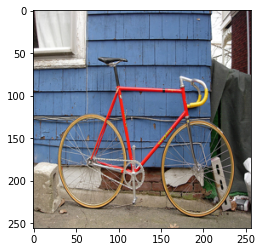

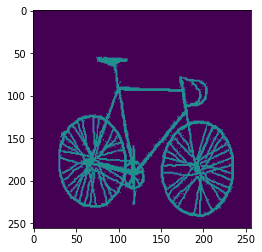

(256, 256, 3)


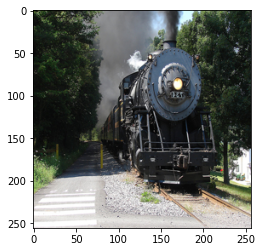

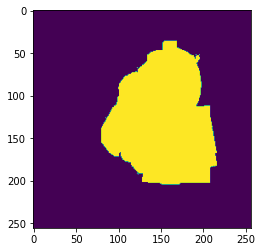

(256, 256, 3)


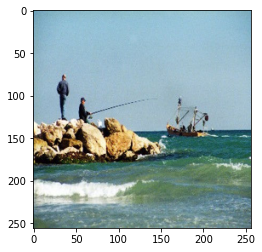

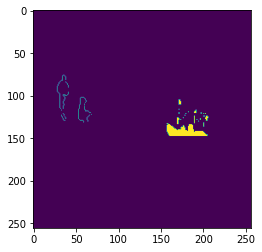

(256, 256, 3)


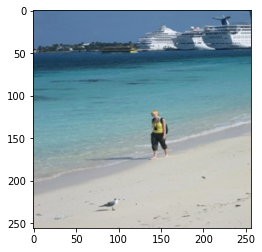

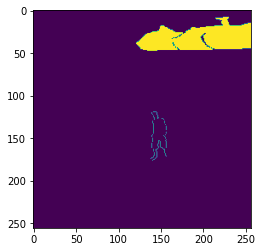

(256, 256, 3)


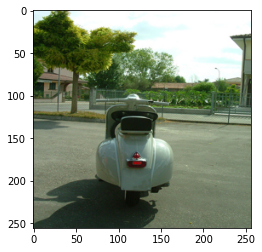

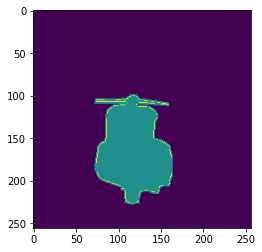

In [24]:
for image, mask in train.take(5):
    sample_image, sample_mask = image, mask
    plt.imshow(sample_image)
    print(sample_image.shape)
    plt.show()
    plt.imshow(sample_mask)
    plt.show()

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[IMG_HEIGHT, IMG_WIDTH, 3], include_top=False)

# use the output of listed layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# build the feature extraction model (encoder)
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
# we'll not change the parameter of the decoder
down_stack.trainable = False

In [26]:
# build the upsampling model (decoder)
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [27]:
def unet_model(output_channels):
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 3])
    x = inputs

    # downsampling and extract features 
    skips = down_stack(x)
    x = skips[-1]
    # layers to establish skip connections in the encoder model
    skips = reversed(skips[:-1])

    # establish skip connections between layers of encoder and decoder
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    # the last layer 
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

### find the optimal learning rate

In [28]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
# x, y = next(iter(val_dataset))

# for x_, y_ in val_dataset:
#     x = tf.concat((x, x_), axis=0)
#     y = tf.concat((y, y_), axis=0)
    
# # use lr_finder to draw the cycling learning rate
# lr_finder = LRFinder(model)
# lr_finder.find(x, y, start_lr=1e-10, end_lr=1, batch_size=32, epochs=10)
# lr_finder.plot_loss()

### From the above figure, 1e-4 is the optimal learning rate

In [30]:
optimizer = keras.optimizers.Adam(learning_rate=1e-4)

In [31]:
OUTPUT_CHANNELS = 22
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

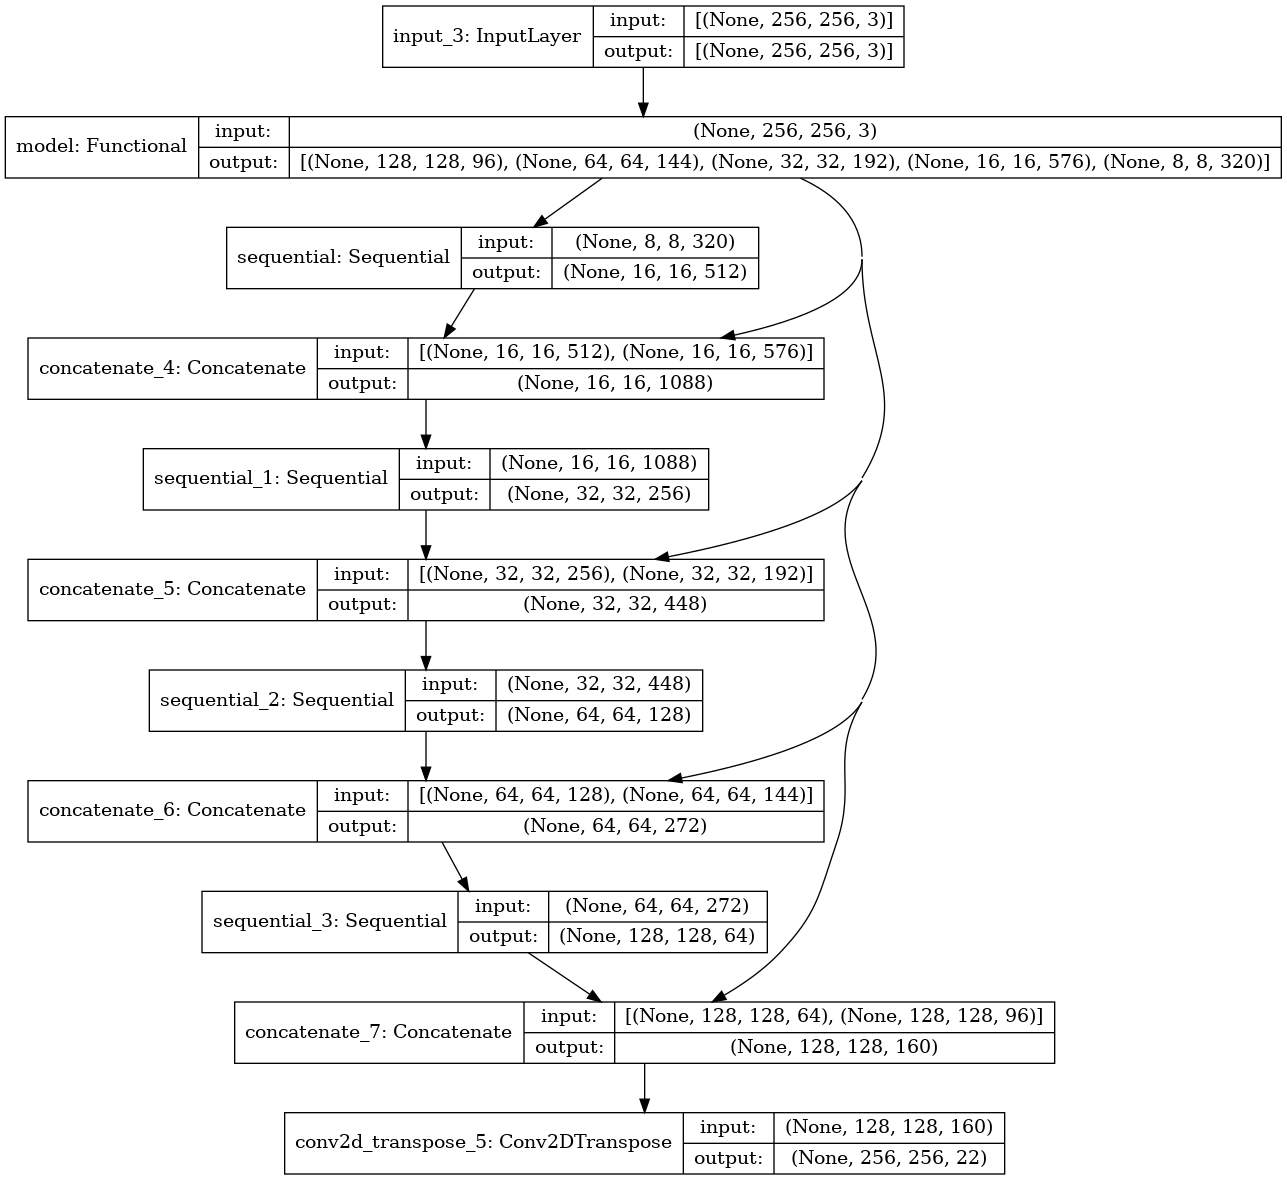

In [32]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [33]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [34]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = val_size//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset)

Epoch 1/50
63/63 [==============================] - 68s 330ms/step - loss: 2.4490 - accuracy: 0.3369 - val_loss: 1.3082 - val_accuracy: 0.7342
Epoch 2/50
63/63 [==============================] - 22s 321ms/step - loss: 0.8484 - accuracy: 0.8807 - val_loss: 0.6184 - val_accuracy: 0.8934
Epoch 3/50
63/63 [==============================] - 20s 325ms/step - loss: 0.4849 - accuracy: 0.9021 - val_loss: 0.4094 - val_accuracy: 0.9065
Epoch 4/50
63/63 [==============================] - 21s 332ms/step - loss: 0.3845 - accuracy: 0.9057 - val_loss: 0.4599 - val_accuracy: 0.8763
Epoch 5/50
63/63 [==============================] - 21s 328ms/step - loss: 0.3270 - accuracy: 0.9108 - val_loss: 0.3443 - val_accuracy: 0.9004
Epoch 6/50
63/63 [==============================] - 20s 323ms/step - loss: 0.2863 - accuracy: 0.9186 - val_loss: 0.2962 - val_accuracy: 0.9108
Epoch 7/50
63/63 [==============================] - 20s 325ms/step - loss: 0.2578 - accuracy: 0.9263 - val_loss: 0.2612 - val_accuracy: 0.9153

In [ ]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(np.array(display_list[i]))
        plt.axis('off')
    plt.show()

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

In [ ]:
show_predictions(train_dataset, num =10)

In [ ]:
show_predictions(test_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
show_predictions(val_dataset.shuffle(buffer_size=64), num =10)

In [ ]:
model.evaluate(test_dataset)

### Model inference and extract mask

In [ ]:
!mkdir source
!mkdir mask

In [ ]:
cnt = 0
for image, mask in train_dataset.take(10):
    pred_mask = model.predict(image)
    pred_mask = create_mask(pred_mask)
    pred_mask = (np.array(pred_mask) !=0).astype(int)
#     print(image[0].shape)
#     print(pred_mask.shape)
    Image.fromarray((np.array(image[0]*255).astype(np.uint8))).save(f"source/source_{cnt}.jpg")
    Image.fromarray((pred_mask[:,:,0]*255).astype(np.uint8)).save(f"mask/mask_{cnt}.jpg")
    display([image[0], pred_mask[:, :, 0], image[0] * pred_mask])
    cnt += 1

In [ ]:
# cat_img = np.array(Image.open("../input/pascal-voc-2012/VOC2012/JPEGImages/2007_000241.jpg").resize((256, 256)))
# pred_mask = model.predict(cat_img[np.newaxis,...])
# mask = create_mask(pred_mask)
# mask = np.array(mask!=0, dtype=int)

In [ ]:
import wandb
from wandb.keras import WandbCallback

In [ ]:
wandb.login(key = '2f9ea9f46398a3991e48c7ad0e211dd29acd44b5')

In [ ]:
sweep_config = {
    "name": "sweep_test_cv",
    "metric": {"name": "val_loss", "goal": "minimize"},
    "method": "random",
    "parameters": {
        "learning_rate" : {
            "min" : 0.001,
            "max" : 0.1
            },
        "epoch" : {
            "distribution" : "int_uniform",
            "min" : 5,
            "max" : 10
            }
                    
        }
    }

In [ ]:
def train():
    default_config = {
        "input" : (256,256,3),
        "filter" : 8,
        "kernel" : (3,3),
        "learning_rate" : 0.005,
        "optimizer" : "adam",
        "metrics" : ["accuracy"],
        "epoch" : 5,
        "batch_size" : 32
    }

    wandb.init(config = default_config)
    config = wandb.config


    # 머신 러닝 학습때 여러가지 optimzier를 사용할 경우나 learning rate를 조절할 경우에는 아래와 같은 형태의 코드를 응용합니다.

    if config.optimizer == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate = config.learning_rate)
    
    model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=config.metrics)

    # WandbCallback 함수는 후술합니다.
    model.fit(train_dataset,
              epochs=config.epoch,
              steps_per_epoch=STEPS_PER_EPOCH,
              validation_steps=VALIDATION_STEPS,
              validation_data=val_dataset,
              callbacks = [WandbCallback(validation_data = val_dataset,
                                         predictions = 10,
                                         input_type = "auto",
                                         output_type = "segmentation_mask")])
    
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
    
    # wandb.log 함수 안에 기록하고 싶은 정보를 담습니다.
    
    wandb.log({"Test Accuracy Rate: " : round(test_accuracy * 100, 2),
               "Test Error Rate: " : round((1 - test_accuracy) * 100, 2)})

In [ ]:
# entity와 project에 본인의 아이디와 프로젝트명을 입력하세요

sweep_id = wandb.sweep(sweep_config,
                       entity = None,
                       project = 'test_project')

# run the sweep
wandb.agent(sweep_id,
            function=train,
            count=10)